In [1]:
import re
import string
import json
import joblib
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection,metrics


#machine learning models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_state = np.random.RandomState(0)

<IPython.core.display.Javascript object>

In [2]:
# load chats to chatData from Chatbot file
file = open('ChatbotCorpus.json',)
chatData = json.load(file)
file.close()

### Approach 1

In [3]:
#chatboat DataFrame to store text and intents
chatDF = pd.DataFrame(columns=['text','intent'])

#add the data to chatDF
for item in chatData['sentences']:
    chatDF = chatDF.append({'text': item['text'],'intent':item['intent']},ignore_index = True)

chatDF.head()

,text,intent
0,i want to go marienplatz,FindConnection
1,when is the next train in muncher freiheit?,DepartureTime
2,when does the next u-bahn leaves from garching...,DepartureTime
3,from olympia einkaufszentrum to hauptbahnhof,FindConnection
4,when is the next train from winterstraÃŸe 12 t...,FindConnection


In [4]:
chatDF.describe()

,text,intent
count,206,206
unique,201,2
top,how can i get from moosach to quiddestraÃŸe?,FindConnection
freq,2,128


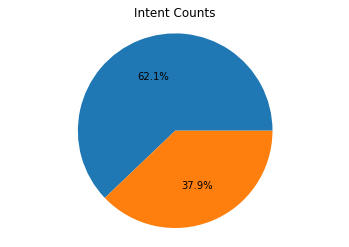

In [5]:
#pie chart for intent counts
fig, ax = plt.subplots()
ax.pie(chatDF.intent.value_counts(), autopct='%1.1f%%')
ax.axis('equal')  
ax.set_title('Intent Counts')
plt.show()

In [6]:
#split the 10% data as test data
test_size = int(chatDF.shape[0]*0.10)
train_data = chatDF.iloc[:len(chatDF)-test_size]
test_data = chatDF.iloc[len(chatDF)-test_size:]

In [7]:
print(f"Train data size {train_data.shape[0]}")
print(f"Test data size {test_data.shape[0]}")

Train data size 186
Test data size 20


### First approach, perpare a vocabulary using traing data and apply tfidf vectorization.

In [8]:
punc = string.punctuation
def remove_punctuation(text):
    """
        Remove the punctuations from the text and return clean text
    """
    text = ''.join([char for char in text if char not in punc]).lower()
    return text

In [9]:
#remove the punctuations from the text data
train_data.text = train_data.text.apply(remove_punctuation)
train_data.head(5)

,text,intent
0,i want to go marienplatz,FindConnection
1,when is the next train in muncher freiheit,DepartureTime
2,when does the next ubahn leaves from garching ...,DepartureTime
3,from olympia einkaufszentrum to hauptbahnhof,FindConnection
4,when is the next train from winterstraãÿe 12 t...,FindConnection


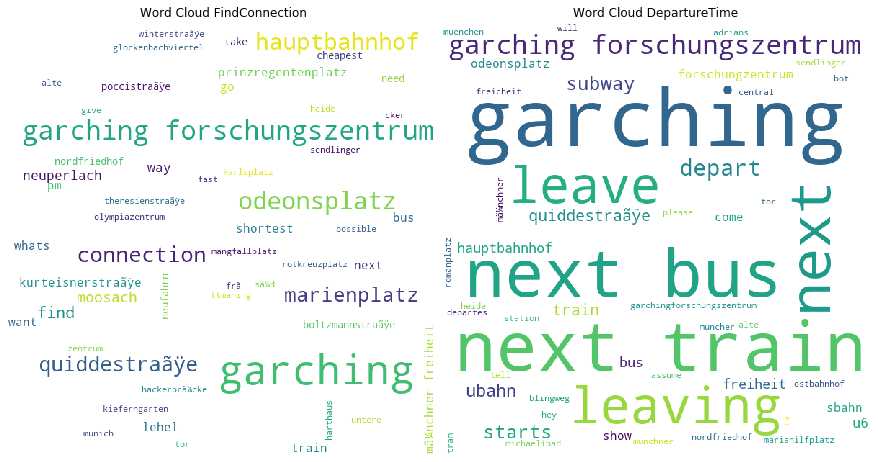

In [10]:
#merge all the text for both classes
train_text_fc = " ".join([text for text in train_data[train_data.intent=='FindConnection'].text])
train_text_dt = " ".join([text for text in train_data[train_data.intent=='DepartureTime'].text])


wordcloud_fc = WordCloud(width = 600, height = 600,
                background_color ='white',
                min_font_size = 10).generate(train_text_fc)

wordcloud_dt = WordCloud(width = 600, height = 600,
                background_color ='white',
                min_font_size = 10).generate(train_text_dt)
  
# plot the WordCloud image                       
plt.figure(figsize = (12, 8), facecolor = None)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fc)
plt.title("Word Cloud FindConnection")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_dt)
plt.title("Word Cloud DepartureTime")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [11]:
#convert intent to binary class 0 and 1
train_data['intent'] = train_data['intent'].replace({'FindConnection': 0, 'DepartureTime': 1})
train_data.head(5)

,text,intent
0,i want to go marienplatz,0
1,when is the next train in muncher freiheit,1
2,when does the next ubahn leaves from garching ...,1
3,from olympia einkaufszentrum to hauptbahnhof,0
4,when is the next train from winterstraãÿe 12 t...,0


## TF-IDF Vectorization

In [12]:
vectorizer = TfidfVectorizer()

#fit vectorizer on training data
vectorizer.fit(train_data.text)

#generate tf-idf matrix from training data
X= vectorizer.transform(train_data.text)

#features for the chat data
print(vectorizer.get_feature_names())

['12', '21', 'adrians', 'airport', 'alte', 'am', 'and', 'around', 'as', 'assling', 'assume', 'at', 'be', 'between', 'blingweg', 'boltzmannstraãÿe', 'bonner', 'bot', 'brudermã¼hlstraãÿe', 'bus', 'can', 'central', 'cheapest', 'city', 'cker', 'come', 'comes', 'connection', 'could', 'depart', 'departes', 'departs', 'do', 'does', 'east', 'einkaufszentrum', 'endgarching', 'fast', 'fastest', 'feldmoching', 'find', 'forschungszentrum', 'forschungzentrum', 'foschungszentrum', 'freicheit', 'freiheit', 'freimann', 'from', 'frã', 'garching', 'garchingforschungszentrum', 'garchingto', 'get', 'give', 'glockenbachviertel', 'go', 'hackerbrã¼cke', 'harras', 'harthaus', 'hauptbahnhof', 'hbf', 'heide', 'hello', 'hey', 'hohenlindenerstr', 'hohenlindenerstraãÿe', 'how', 'implerstraãÿe', 'in', 'is', 'karlpreisplatz', 'karlsplatz', 'kieferngarte', 'kieferngarten', 'klinikum', 'klinkum', 'kurteisnerstraãÿe', 'laim', 'leave', 'leaves', 'leaving', 'lehel', 'mangfallplatz', 'mariahilfplatz', 'marienplatz', 'me',

In [13]:
#convert tf-idf matrix to dataframe
train_df = pd.DataFrame.sparse.from_spmatrix(X)
train_df['intent'] = train_data['intent']  

#perform data preprocessing on test and generate fetures
test_data.text = test_data.text.apply(remove_punctuation)
test_df = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(test_data.text))

#convert test labels to numerical form 
test_df['intent'] = list(test_data['intent'].replace({'FindConnection': 0, 'DepartureTime': 1}))

In [14]:
def train_model(df,test_df,model,k):
    """
    Agrs:
        df(Pandas dataframe) : Training Data for the model 
        test_df(pandas dataframe) : Test data for the model
        model (sklearn ml model): Model to fit an training data
        k(int) : number of folds
    Return:
        Return model after fitting on training data
    """
    #create k folds
    df["kfold"] = -1
    kf = model_selection.StratifiedKFold(n_splits=k)
    for f,(t_,v_) in enumerate(kf.split(X=df,y=df.intent)):
        df.loc[v_,'kfold'] = f

    #train model on different folds and predict results
    for fold in range(0,k):
        scores = []
        df_train = df[df["kfold"] != fold].reset_index(drop=True)
        df_valid = df[df["kfold"] == fold].reset_index(drop=True)
        
        x_train = df_train.drop(['kfold','intent'],axis=1).values
        y_train = df_train.intent.values
    
        x_valid = df_valid.drop(['kfold','intent'],axis=1).values
        y_valid = df_valid.intent.values
        
        model.fit(x_train,y_train)
        y_pred = model.predict(x_valid)
        
        scores.append(metrics.accuracy_score(y_valid,y_pred))

    score = np.mean(scores) 
    print(f"Accuracy score for the model : {score}")

    print("Reuslts on Train Data......")
    X_train = df.drop(["intent","kfold"],axis=1)
    y_train = df['intent']
    #metrics.plot_confusion_matrix(model,X_train.values,y_train,display_labels=["FindConnection","DepartureTime"],cmap=plt.cm.Blues)
    y_pred = model.predict(X_train.values)
    print(metrics.classification_report(y_train,y_pred))


    print("\n\n Results for Test Data......")
    X_test = test_df.drop("intent",axis=1)
    y_test = test_df["intent"]
    #metrics.plot_confusion_matrix(model,X_test.values,y_test,display_labels=["FindConnection","DepartureTime"],cmap=plt.cm.Blues)
    y_pred = model.predict(X_test.values)
    print(f"Accuracy on test data {metrics.accuracy_score(y_test,y_pred)}")
    print(metrics.classification_report(y_test,y_pred))
    return model

In [15]:
#initialise different machine learning models
svc_classifier = SVC(C=100)
rf_clf = RandomForestClassifier(n_estimators=100,)
nb_clf = GaussianNB()

#dictonary of machin learning models
ml_models = {"SVC":svc_classifier,"Random Forest Classifier":rf_clf,"Naive Bayes":nb_clf }

#train each machine learning model
for model_name in ml_models.keys():
    print(model_name)
    model = ml_models[model_name]
    ml_models[model_name] = train_model(train_df,test_df,model,k=3)
    print("\n")

SVC


<IPython.core.display.Javascript object>

Accuracy score for the model : 0.9516129032258065
Reuslts on Train Data......
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       112
           1       0.99      0.97      0.98        74

    accuracy                           0.98       186
   macro avg       0.98      0.98      0.98       186
weighted avg       0.98      0.98      0.98       186



 Results for Test Data......
Accuracy on test data 0.95
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.80      1.00      0.89         4

    accuracy                           0.95        20
   macro avg       0.90      0.97      0.93        20
weighted avg       0.96      0.95      0.95        20



Random Forest Classifier


<IPython.core.display.Javascript object>

Accuracy score for the model : 0.9354838709677419
Reuslts on Train Data......
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       112
           1       0.97      0.97      0.97        74

    accuracy                           0.98       186
   macro avg       0.98      0.98      0.98       186
weighted avg       0.98      0.98      0.98       186



 Results for Test Data......
Accuracy on test data 0.95
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.80      1.00      0.89         4

    accuracy                           0.95        20
   macro avg       0.90      0.97      0.93        20
weighted avg       0.96      0.95      0.95        20



Naive Bayes


<IPython.core.display.Javascript object>

Accuracy score for the model : 0.9354838709677419
Reuslts on Train Data......
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       112
           1       0.96      0.99      0.97        74

    accuracy                           0.98       186
   macro avg       0.98      0.98      0.98       186
weighted avg       0.98      0.98      0.98       186



 Results for Test Data......
Accuracy on test data 0.9
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.50      0.67         4

    accuracy                           0.90        20
   macro avg       0.94      0.75      0.80        20
weighted avg       0.91      0.90      0.89        20





## Changing Training Data Size

In [16]:
#split the 30% data as test data
test_size = int(chatDF.shape[0]*0.30)
train_data = chatDF.iloc[:len(chatDF)-test_size]
test_data = chatDF.iloc[len(chatDF)-test_size:]

#number of records in train and test data
print(f"Train data size {train_data.shape[0]}")
print(f"Test data size {test_data.shape[0]}")

Train data size 145
Test data size 61


In [17]:
vectorizer = TfidfVectorizer()

#fit vectorizer on training data
vectorizer.fit(train_data.text)

#generate tf-idf matrix from training data
X= vectorizer.transform(train_data.text)

#features for the chat data
print(vectorizer.get_feature_names())

#convert tf-idf matrix to dataframe
train_df = pd.DataFrame.sparse.from_spmatrix(X)
train_df['intent'] = list(train_data['intent'].replace({'FindConnection': 0, 'DepartureTime': 1}))  

#perform data preprocessing on test and generate fetures
test_data.text = test_data.text.apply(remove_punctuation)
test_df = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(test_data.text))

#convert test labels to numerical form 
test_df['intent'] = list(test_data['intent'].replace({'FindConnection': 0, 'DepartureTime': 1}))

['12', '21', 'airport', 'alte', 'am', 'and', 'around', 'as', 'assling', 'assume', 'at', 'be', 'between', 'boltzmannstraãÿe', 'bonner', 'bot', 'brudermã¼hlstraãÿe', 'bus', 'can', 'central', 'cheapest', 'city', 'cker', 'connection', 'could', 'depart', 'departs', 'do', 'does', 'east', 'einkaufszentrum', 'endgarching', 'fast', 'fastest', 'feldmoching', 'find', 'forschungszentrum', 'forschungzentrum', 'foschungszentrum', 'freicheit', 'freiheit', 'freimann', 'from', 'frã', 'garching', 'garchingforschungszentrum', 'get', 'give', 'glockenbachviertel', 'go', 'hackerbrã¼cke', 'harras', 'harthaus', 'hauptbahnhof', 'hbf', 'heide', 'hello', 'hohenlindenerstr', 'hohenlindenerstraãÿe', 'how', 'implerstraãÿe', 'in', 'is', 'karlpreisplatz', 'karlsplatz', 'kieferngarte', 'kieferngarten', 'klinikum', 'klinkum', 'kurteisnerstraãÿe', 'laim', 'leave', 'leaves', 'leaving', 'lehel', 'mangfallplatz', 'marienplatz', 'me', 'milbertshofen', 'moosach', 'moosfeld', 'mossach', 'muenchen', 'muncher', 'munchner', 'mun

In [22]:
#initialise different machine learning models
svc_classifier = SVC(kernel="sigmoid")
rf_clf = RandomForestClassifier(n_estimators=100,)
nb_clf = GaussianNB()

#dictonary of machin learning models
ml_models = {"SVC":svc_classifier,"Random Forest Classifier":rf_clf,"Naive Bayes":nb_clf }

#train each machine learning model
for model_name in ml_models.keys():
    print(model_name)
    model = ml_models[model_name]
    ml_models[model_name] = train_model(train_df,test_df,model,k=3)
    print("\n")

SVC


<IPython.core.display.Javascript object>

Accuracy score for the model : 1.0
Reuslts on Train Data......
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        45

    accuracy                           1.00       145
   macro avg       1.00      1.00      1.00       145
weighted avg       1.00      1.00      1.00       145



 Results for Test Data......
Accuracy on test data 0.9672131147540983
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.94      1.00      0.97        33

    accuracy                           0.97        61
   macro avg       0.97      0.96      0.97        61
weighted avg       0.97      0.97      0.97        61



Random Forest Classifier


<IPython.core.display.Javascript object>

Accuracy score for the model : 0.9791666666666666
Reuslts on Train Data......
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.98      0.99        45

    accuracy                           0.99       145
   macro avg       1.00      0.99      0.99       145
weighted avg       0.99      0.99      0.99       145



 Results for Test Data......
Accuracy on test data 0.9672131147540983
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.94      1.00      0.97        33

    accuracy                           0.97        61
   macro avg       0.97      0.96      0.97        61
weighted avg       0.97      0.97      0.97        61



Naive Bayes


<IPython.core.display.Javascript object>

Accuracy score for the model : 0.9166666666666666
Reuslts on Train Data......
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.94      0.98      0.96        45

    accuracy                           0.97       145
   macro avg       0.96      0.97      0.97       145
weighted avg       0.97      0.97      0.97       145



 Results for Test Data......
Accuracy on test data 0.9180327868852459
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        28
           1       1.00      0.85      0.92        33

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.93      0.92      0.92        61





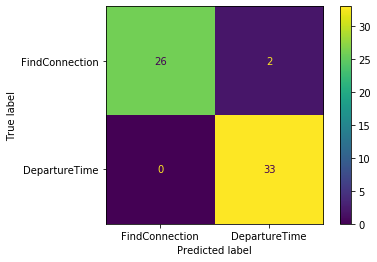

In [24]:
#Plot confusion matrix for test data
X_test = test_df.drop("intent",axis=1)
y_test = test_df["intent"]
metrics.plot_confusion_matrix(svc_classifier,X_test.values,y_test,display_labels=["FindConnection","DepartureTime"])

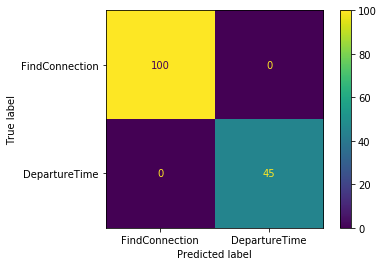

In [25]:
#Plot confusion matrix for train data
X_train = train_df.drop(["intent","kfold"],axis=1)
y_train = train_df['intent']
metrics.plot_confusion_matrix(svc_classifier,X_train.values,y_train,display_labels=["FindConnection","DepartureTime"])

In [26]:
#save random forest model and vectorizer
joblib.dump(svc_classifier,"./model/svc_classifier.pkl")
joblib.dump(vectorizer,"./utils/vectorizer.pkl")

['./utils/vectorizer.pkl']

In [27]:
def predict(input):
    assert(type(input) == str)

    #preprocess text
    input = ''.join([char for char in input if char not in punc]).lower()
    input = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform([input]))

    #model prediction
    prediction = svc_classifier.predict(input.values)

    if prediction[0] == 0: return "FindConnection"
    else: return "DepartureTime"

In [37]:
input = "when does the next train come at garching forschungszentrum"
print(f"intent : {predict(input)}")

intent : DepartureTime
